# Final Challenge - VQE for LiH molecule
Have a look to the [notebook of Ex5](https://github.com/qiskit-community/ibm-quantum-challenge-2021/blob/main/content/ex5/ex5.ipynb) to read the problem statement!


## Get relevant information about the LiH molecule by applying a driver
Here, we will use the [`PySCFDriver`](https://qiskit.org/documentation/stubs/qiskit.chemistry.drivers.PySCFDriver.html) in order to get relevant information about the LiH molecule.

In [1]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(molecule)
qmolecule = driver.run()

n_electrons = qmolecule.num_alpha + qmolecule.num_beta
n_molecular_orbitals = qmolecule.num_molecular_orbitals
orbital_energies = qmolecule.orbital_energies
core_orbitals = qmolecule.core_orbitals
n_spin_orbitals = 2*n_molecular_orbitals
n_jw_qubits = n_spin_orbitals

print(f"What is the total number of electrons? {n_electrons}")
print(f"What is the number of molecular orbitals? {n_molecular_orbitals}")
print(f"What is the index of the core orbital? {core_orbitals}")
print(f"What is the number of spin-orbitals? {n_spin_orbitals}")
print(f"How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? {n_jw_qubits}")

What is the total number of electrons? 4
What is the number of molecular orbitals? 6
What is the index of the core orbital? [0]
What is the number of spin-orbitals? 12
How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? 12


## Reducing the problem size
Here we will reduce the size of the qubit operator.  
By reducing the number of qubits needed to encode the qubit operator, the number of qubits needed to encode the ansatz will decrease accordingly.

Let's begin by understanding how many qubits are required in order to encode the qubit operator if no simplification is done.

In [2]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

original_problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = original_problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper=JordanWignerMapper()
original_converter = QubitConverter(mapper=mapper)
qubit_op = original_converter.convert(main_op, num_particles=n_electrons)
print("The number of qubits needed in order to encode the qubit operator " \
      f"if no simplification is done is {qubit_op.num_qubits}.")

The number of qubits needed in order to encode the qubit operator if no simplification is done is 12.


Now, let's work in order to simplify the problem.  

### Transformers

Orbitals are filled starting from the lowest energy ones. Each molecular orbital can be occupied by 2 electrons (spin $\uparrow$, spin $\downarrow$). Since LiH has 4 electrons and 6 molecular orbitals, our molecule has 2 molecular orbitals that are occupied (indices 0 and 1) and 4 molecular orbitals that are unoccupied (indices from 2 to 5 included). Each molecular orbital that we will be able to neglect by still maintaining an acceptable accuracy fot the solution will save us 2 qubits (1 qubit per spin orbital).

By using the [`FreezeCoreTransformer`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.transformers.FreezeCoreTransformer.html) we can get rid of the molecular orbitals that do not contribute significantly to the calculation of the ground state energy. Specifically, we will:
- set the argument `freeze_core` to `True` (default). This will allow us to remove the *core orbital* of LiH, that is the lowest energy molecular orbital (index 0). Its contribution to the ground state energy is more or less fixed. Therefore, we can neglect it in the computation, and threat it as a constant shift by adding up its contribution to the ground state energy afterwards. **This will save us 2 qubits.**
- set the argument `remove_orbitals` to `[3,4]`. This will allow us to remove the 3rd and 4th orbitas of LiH, neglecting their contribution in the computation of the ground state energy. **This will save us 4 qubits.**

First, we will check that the effect of the above simplifications is the one that we expected:

In [3]:
from qiskit_nature.transformers import FreezeCoreTransformer
freezeCoreTransfomer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])
qmolecule_transf = freezeCoreTransfomer.transform(qmolecule)

n_electrons_transf = qmolecule_transf.num_alpha + qmolecule_transf.num_beta
n_molecular_orbitals_transf = qmolecule_transf.num_molecular_orbitals
n_spin_orbitals_transf = 2*n_molecular_orbitals_transf
n_jw_qubits_transf = n_spin_orbitals_transf

print(f"What is the total number of electrons in your system? {n_electrons_transf}")
print(f"What is the number of molecular orbitals? {n_molecular_orbitals_transf}")
print(f"What is the number of spin-orbitals? {n_spin_orbitals_transf}")
print(f"How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? {n_jw_qubits_transf}")

What is the total number of electrons in your system? 2
What is the number of molecular orbitals? 3
What is the number of spin-orbitals? 6
How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? 6


NB: try not to pass the `remove_orbitals` argument to see how the answers change!

Then, we will actually apply the above simplifications:

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

freezeCoreTransfomer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

### Mapper and Qubit Converter

Certain fermion-to-qubit mappers, such as the [`ParityMapper`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.ParityMapper.html#qiskit_nature.mappers.second_quantization.ParityMapper), can reduce the size of the qubit operator by two qubits by exploiting symmetries during the mapping.  
By setting to `True` the argument `two_qubit_reduction` of the [`QubitConverter`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.converters.second_quantization.QubitConverter.html), we will tell the qubit converter to apply the two qubit reduction if possibile (that is, if the mapper supports it and the number of particles in the system is given). **This will save us 2 qubits.**

In [5]:
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

# Setup the mapper and qubit converter
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(f"The number of qubits of the qubit operator so obtained is {qubit_op.num_qubits}")

The number of qubits of the qubit operator so obtained is 4


NB: try not to pass the `two_qubit_reduction` argument to see how the answer changes!

### A quick check

Having applied some simplifications, we can now check that the error introduced by the above simplifications is within the chemical accuracy of 4 mHa.

In [6]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(original_problem, original_converter)
exact_electronic_energy = np.real(result_exact.electronic_energies[0])
print(f"The exact electronic ground state energy is {exact_electronic_energy} Ha")

result = exact_diagonalizer(problem, converter)
electronic_energy = np.real(result.electronic_energies[0])
frozen_core_energy = result._extracted_transformer_energies['FreezeCoreTransformer']
print(f"The electronic ground state energy resulting after applying the above simplifications is {electronic_energy} Ha")

print(f'The error introduced by the above simplifications is {1000*abs(exact_electronic_energy-electronic_energy)} mHa')

The exact electronic ground state energy is -8.908697116424262 Ha
The electronic ground state energy resulting after applying the above simplifications is -8.907396311315885 Ha
The error introduced by the above simplifications is 1.3008051083769345 mHa


## Solve the problem
Here we will use the simplified qubit operator that we obtained in order to solve the problem using VQE.  
Now that the size of the qubit operator has been reduced, we will be able to reach the solution with a small ansatz (simple problem, simple ansatz!)

### Ansatz
Let's build the ansatz. In doing this, we will try to limit the number of CNOT gates to the mimimum that will still allow us to reach the goal (in the end, $score = N_{CNOT}$, isn't it?).

First, we define the initial state to be the Hartree-Fock state:

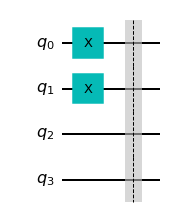

In [7]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 *problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.barrier()
init_state.draw()

Then, we take a standard variational form such as [`Real Amplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html). In order to limit the number of CNOT gates to 3, we will:
- set the argument `reps` to `1`. This will allow to obtain a variational form that is composed of a single elementary building-block (circuit), instead of stacking several of them.
- set the argument `entanglement` to linear. This will allow to entangle qubit $i$ to qubit $i+1$. Since we are dealing with 4 qubits, it is easy to see that this will limit to 3 the number of CNOT gates used by each elementary building-block that composes our variational form.

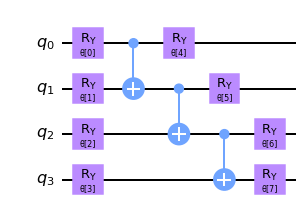

In [8]:
from qiskit.circuit.library import RealAmplitudes
variational_form = RealAmplitudes(qubit_op.num_qubits, reps=1, entanglement='linear')
variational_form.draw()

Then, we create our custom variational form by just modifying the Real Amplitudes circuit a little by displacing the last Ry gates in order to put them between the adjacent CNOTs:

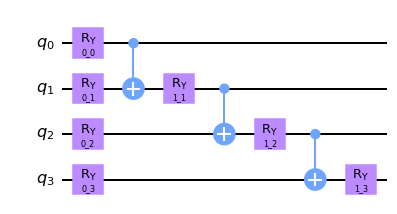

In [9]:
from qiskit.circuit import QuantumCircuit, Parameter

n = qubit_op.num_qubits
qc = QuantumCircuit(qubit_op.num_qubits)

for j in range(n): 
    qc.ry(Parameter(f'0_{j}'), j)
for j in range(n-1):
    qc.cx(j, j+1)
    qc.ry(Parameter(f'1_{j+1}'), j+1)
    
variational_form = qc
variational_form.draw()

Finally, we obtain the ansatz by composing the initial state and the variational form:

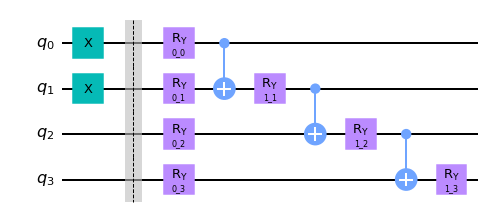

In [10]:
ansatz = init_state.compose(variational_form)
ansatz.draw()

We will see that even a small ansatz like this is enough.

### VQE

VQE needs a classical optimizer in order to find the optimal parameters of the circuit (parameters that, in our case, are the rotation angles associated to the Ry gates of the ansatz). We will stick to [`L_BFGS_B`](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.L_BFGS_B.html) (but you can also try with other classical optimizers like [`COBYLA`](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html). In this case, increase the maximum number of iterations `maxiter` in order to be able to converge or at least to limit the truncation error).

In [11]:
from qiskit.algorithms.optimizers import L_BFGS_B 
optimizer = L_BFGS_B()

Time to run VQE!

In [12]:
from qiskit import Aer
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

backend = Aer.get_backend('statevector_simulator') 

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    vqe_energy = frozen_core_energy+mean
    abs_error = abs(exact_electronic_energy-vqe_energy)
    display(f"Iteration: {eval_count}, Energy: {vqe_energy} Ha, absolute error: {1000*abs_error} mHa")
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(vqe_energy)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters


algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

'Iteration: 904, Energy: -8.904945838557593 Ha, absolute error: 3.7512778666695112 mHa'

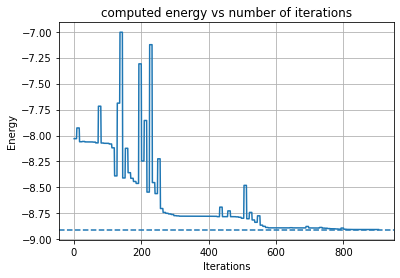

In [13]:
# Display results 
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import matplotlib.pyplot as plt

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

fig, ax = plt.subplots(1, 1)
plt.title(f"computed energy vs number of iterations")
ax.set_ylabel('Energy')
ax.set_xlabel('Iterations')
ax.grid()
ax.axhline(exact_electronic_energy, linestyle='--')
ax.plot(counts, values)

In [14]:
vqe_energy = frozen_core_energy+result.eigenvalue
abs_error = abs(vqe_energy - exact_electronic_energy)
print(f"Does the found solution reach the chemical accuracy of 4 mHa? {'Yes' if abs_error<0.004 else 'No'}")

Does the found solution reach the chemical accuracy of 4 mHa? Yes
